<h1 style = "text-align:center; font-size:300%"> Tarea: Análisis de Tweets </h1>
<h4 style = "text-align:center; font-size:150%">Rubén Giménez Martín</h4>
<br>

**Capturar y procesar tweets con el objetivo de analizar alguna situación, evento, etc actual ...**

-------------------------------------------
#### Introducción
En el siguiente trabajo se realizará la captura y el procesamiento de tweets con el objetivo de poder medir y analizar la consecución de un evento a través de Twitter.

El evento elegido para la realización de este trabajo fue un evento deportivo, concretamente, se trató del partido de fútbol disputado a las 20:00h (hora del Reino Unido) el día 26 de Abril en el estadio de Anfield entre el Liverpool FC y el Huddersfiel Town. 
<img src="https://www.esatoursportevents.com/wp-content/uploads/2015/09/liverpool-huddersfield.jpg" width="600">

Se trataba de un partido significativamente importante para el Liverpool FC, ya que, a falta de 4 jornadas para finalizar la Premier League, el equipo se encontraba a tan solo un punto de diferencia del primer clasificado, el Manchester City, por lo tanto, no se podía permitir perder ante un rival ya descendido. Se determinó que se trataba de un evento de interés para determinar la polaridad de los fans del equipo de Liverpool en Twitter, ya que, a priori, a pesar de ser un partido de relativa facilidad, la consecución de los tres puntos era poco significativa, ya que se daba por hecho que el Manchester City no iba a perder el día de después y se iba a mantener la ventaja de un punto, situación que, si se prolonga en las siguientes 3 jornadas, llevaría irremediablemente al Liverpool FC a perder la Premier League por tan solo un punto de diferencia y con el golaveraje ganado.

Dicho partido fue finalmente ganado por el Liverpool FC por 5 goles a 0. Un día después, el Manchester City ganaría su partido contra el Burnley FC (como se esperaba) por 0 goles a 1.

La captura de los tweets utilizados comenzó a la media hora de comenzar el evento, para ello, se determinó que era más que suficiente utilizar como única palabra clave "liverpool". Se realizó la captura de manera intermitente en 4 momentos: 
1. Desde media hora después del comienzo del evento, hasta aproximadamente el inicio de la segunda mitad.

2. Desde el minuto 60 de juego hasta el 75.

3. Desde el minuto 85 hasta el fin del evento y durante 15 minutos después.

17003 tweets y su información complementaria proporcionada por la API de Twitter fueron escuchados y almacenados en MongoDB a través del código del siguiente chunk, el cual también se puede encontrar en el script llamado *liverpool_tweet_simple_listener.py*. Los datos fueron exportados posteriormente a un archivo *.csv* para ser tratados (script *mongoDB_data_extractor.py*).

El objetivo del trabajo es analizar la manera en la que se vivió el evento a través de Twitter. Se estudiarán:
+ Las lenguas, las localizaciones, las palabras y los hashtags más utilizados, así como los usuarios más mencionados.

+ Se llevará a cabo la visualización de un gráfico tipo wordcloud con las palabras más utilizadas.

+ Finalmente, se llevará a cabo un breve análisis de polaridad de los tweets recopilados.

#### Listener & Extractor

**Librerias**

In [1]:
import os
import numpy as np
import pandas as pd
from itertools import product

import folium
from folium.plugins import MarkerCluster
import geocoder

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib import cm

import re
from nltk.corpus import stopwords
import string

from PIL import Image
from wordcloud import WordCloud
import random

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import preprocessor as p #from the tweet-preprocessor package

**Funciones utilizadas**

In [2]:
# defining tokenisation functions
def tokenise(s):
    return tokens_re.findall(s)

def text_preprocess(s, lowercase=False):
    tokens = tokenise(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

# function for plotting counter tables as horizontal barplots
def counter_plotter(data, values, title = "", xlab = "Count", ylab = ""):
    """
    data arg must be a pandas series
    """
    aux = data[0:values].sort_values()
    x = np.arange(aux.shape[0])
    names = aux.index
    counts = aux.values
    plt.figure(figsize=(10,8))
    plt.barh(names, counts, edgecolor="grey", color=sns.cubehelix_palette(len(counts),start=.5, rot=-.75))
    plt.yticks(x, names, fontsize=10)
    plt.xticks(fontsize=10)
    plt.title(title, fontsize=15, y= 1.02)
    plt.xlabel(xlab,fontsize=10)
    plt.ylabel(ylab, fontsize=10)
    for i, v in enumerate(counts):
        plt.text(v  , i - 0.4 , s = str(v), color = "black", fontsize = 10)
    plt.show()
    
# defining colour function, red colors will be OBVIOUSLY used
def red_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(357, 100%%, %d%%)" % random.randint(60, 100)

### Análisis Simple

De toda la información proporcionada para cada tweet, se decide analizar la lengua en la que los tweets han sido escritos, así como la localización de aquellos usuarios que la hayan compartido.

In [3]:
# importing the livverpool.csv file which includes the raw data collected by
# the listener previously
raw_path = "data/liverpool.csv"
raw_df = pd.read_csv(raw_path, header = 0, delimiter = ",", low_memory = False)
# importing country country_codes
country_codes_path = "data/country_codes.xlsx"
country_codes = pd.read_excel(country_codes_path, header = 0)

print("Initial Data Frame shape:", raw_df.shape)

Initial Data Frame shape: (17003, 39)


**Exploración de idiomas utilizados**

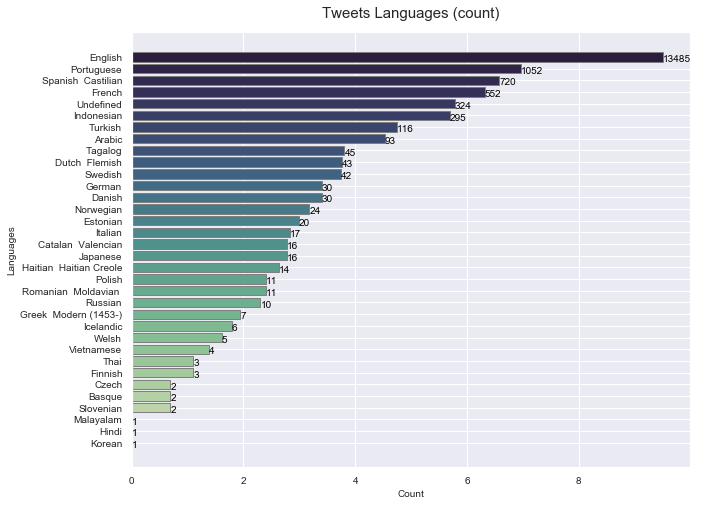

In [4]:
# languages collected
raw_df.lang.unique()

lang_counts = raw_df.lang.value_counts()
lang_counts = pd.DataFrame({"code":lang_counts.index, "Count":lang_counts.values})
# merging for getting real languages names
lang_counts = pd.merge(lang_counts, country_codes, on = "code")#.loc[:,["language", "Count"]]

# adding log(Counts)
lang_counts["log_Count"] = np.log(lang_counts.Count.values)
lang_counts = lang_counts.sort_values(["Count"]).reset_index()


# plotting a simple barplot
x = np.arange(lang_counts.shape[0])
names = lang_counts.language.values
counts_ticks = lang_counts.Count.values
counts = lang_counts.log_Count.values

# TODO: To check how the fuck I can print normal values while plotting logs
plt.figure(figsize=(10,8))
plt.barh(names, counts, edgecolor="grey", color=sns.cubehelix_palette(len(counts),start=.5, rot=-.75))
plt.yticks(x, names, fontsize=10)
plt.xticks(fontsize=10)
plt.title("Tweets Languages (count)", fontsize=15, y= 1.02)
plt.xlabel("Count",fontsize=10)
plt.ylabel("Languages", fontsize=10)
k = -1
for i, v in enumerate(counts):
    k += 1
    label = counts_ticks[k]
    plt.text(v  , i - 0.4 , s = str(label), color = "black", fontsize = 10)
plt.show()

El gráfico inferior representa en escala logarítmica, para una mejor visualización (aunque las etiquetas muestran la escala original) las lenguas en las que, según los datos, cada tweet fue escrito. Se observa que predominaron los tuits en inglés, seguidos muy de lejos por aquellos escritos en portugués y en castellano.

**Aproximación de los principales localizaciones desde donde se tuiteó**

De los 17003 tweets obtenidos, tan solo 378 fueron tuiteados con la geolocalización por defecto activada. Sin embargo, la muestra parece ser bastante significativa.

El mapa inferior muestra la localización de las ciudades desde donde estos 378 tweets fueron enviados. Como era de esperar, la mayoría de ellos provienen de Europa, concretamente Reino Unido, seguidos de América del Sur, América del Norte y África. Al clicar en cada pin del mapa, se muestra las veces que se tuiteó desde dicha ubicación.

In [5]:
# places
# tweets with place mark
print("Number of tweets with geolocation:",len(raw_df.place[raw_df.place.notnull()]))

Number of tweets with geolocation: 378


In [6]:
# saving those places
places = raw_df.place[raw_df.place.notnull()].reset_index().loc[:,["place"]]
places = places.place.values
places_list = []
for i in range(len(places)):
    aux = places[i].split("full_name':")[1].split("', ")[0].split(" '")[1]
    places_list.append(aux)
# saving unique values & counting occurences
places = pd.DataFrame(pd.Series(places_list).value_counts())
places.reset_index(level=0, inplace=True)
places.columns = ["place", "count"]
# fixing bugs (google doesn't even know where Ngapen, Indonesia is!!)...
places.loc[places.place == 'Ngapen, Indonesia', 'place'] = "Ngapa, Indonesia"
places.loc[places.place == 'El Gharbia, Egypt', 'place'] = "Gharbia"

# setting map
m = folium.Map(location=[41.796005, 7.170161],zoom_start=2, tiles = "cartodbdark_matter")
tooltip = 'Times tweeting'
marker_cluster = MarkerCluster().add_to(m)
# setting markers
for i in range(places.shape[0]):
    g = geocoder.osm(places.iloc[i,0])
    lon = g.osm['x']
    lat = g.osm['y']
    coords= [lat, lon]
    folium.Marker(coords, popup=str(places.iloc[i,1]), tooltip=tooltip, icon=folium.Icon(color='#14F074')).add_to(marker_cluster)
    
m

# to see the map visit the html file or run the whole code till this chunk

### Análisis de los textos de los tweets

En este apartado se analizan primeramente, las palabras, los hashtags y los usuarios más mencionados para, posteriormente ser representados en un gráfico WordCloud.

In [7]:
### TEXT ANALYSIS ###
# defining regular expressions to detect emoticon, links, mentions...
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose 
        [D\)\]\(\]/\\OpP] # Mouth
        [:)]   # Single smile
        [:(]   # Single frown
        [:):)] # Two smiles
        [:(:(] # Two frowns
        [:):(] # Mix of a smile and a frown
    )"""

regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs

    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

# selecting texts, for practical reasons, only tweets in English will be chosen
text = raw_df[raw_df.lang == "en"].reset_index()
text = text.text

Se observa una primera muestra de los tweets.

In [8]:
# tweets sample example
print("Muestra de Tweets:")
print(text[77])
print(text[8585])

Muestra de Tweets:
RT @premierleague: GOAL Liverpool 1-0 Huddersfield (1 min)

Nerves, what nerves? Naby Keita presses the ball high up the field before being…
RT @SquawkaNews: Alex Oxlade-Chamberlain has been named in the Liverpool squad against Huddersfield for the first time since his knee injur…


In [9]:
text = text.tolist()
# going for the tokenisation process
tokenised_text = []
for i in range(len(text)):
    tokenised_text.extend(text_preprocess(text[i]))

len(tokenised_text)

# removing stopwords using nltk library
text_clean = [word for word in tokenised_text if word not in stopwords.words("english")]

# a bit of manual process to remove puntuation signs...
puntuation = ["!",".",":", "&", "|", ",", "?", "/", "-", "+" ,"'", ")", "(","[","]","{","}", "=", "’", "…", ";", " ", "I"]
text_clean_2 =  [word for word in text_clean if word not in puntuation]

# and now doing the same for links, which won't be analysed
link = "https"
text_clean_3 = [word for word in text_clean_2 if link not in word]

**Análisis gráfico de las palabras más utilizadas, los hashtags más utilizados y los usuarios más mencionados**

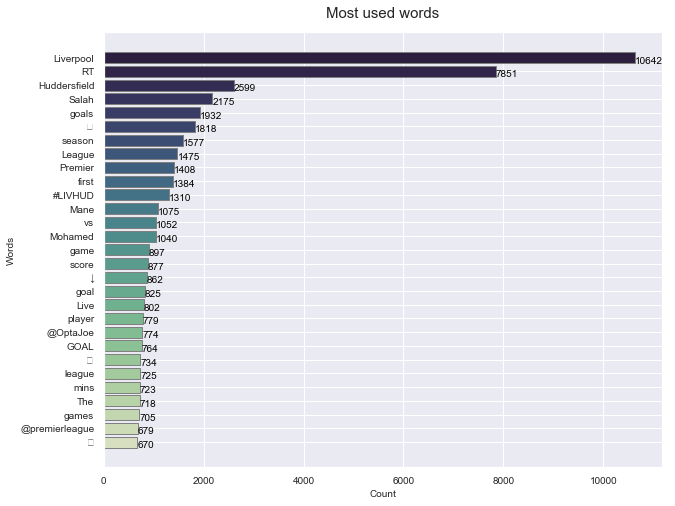

In [10]:
# digits have been removed in this case for a better visualisation
aux = [x for x in text_clean_3 if not any(c.isdigit() for c in x)]
text_clean_count = pd.Series(aux).value_counts()
counter_plotter(data = text_clean_count, values = 29, title = "Most used words", ylab = "Words")

En el gráfico superior, se observa que, evidentemente, la palabra más utilizada fue "Liverpool", seguida por "Huddersfield" (sin contar las siglas "RT" que denotan un retweet). Es significativo observar las palabras "Salah" y "Mane", autores de los 4 de los 5 goles que consiguió meter el Liverpool. De la misma manera, se observa que los usuarios @OptaJoe y @premierleague, se cuelan entre los términos más utilizados, lo que denota que tanto la agencia de noticias deportivas como la cuenta oficial de la liga de fútbol tuvieron una gran actividad e interacciones.

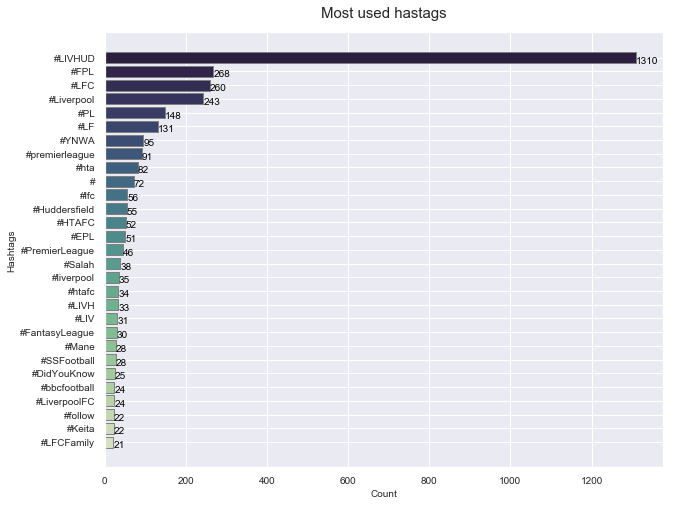

In [11]:
# checking main hashtags used
hash = "#"
hastags = [word for word in text_clean_3 if hash in word]
hastags = pd.Series(hastags).value_counts()
counter_plotter(data = hastags, values = 29, title = "Most used hastags", ylab = "Hashtags")

Como ya se podía observar en el gráfico anterior, el hashtag elegido por la cuenta oficial de la liga (@premierleague) se impuso siendo el hashtag más utilizado.

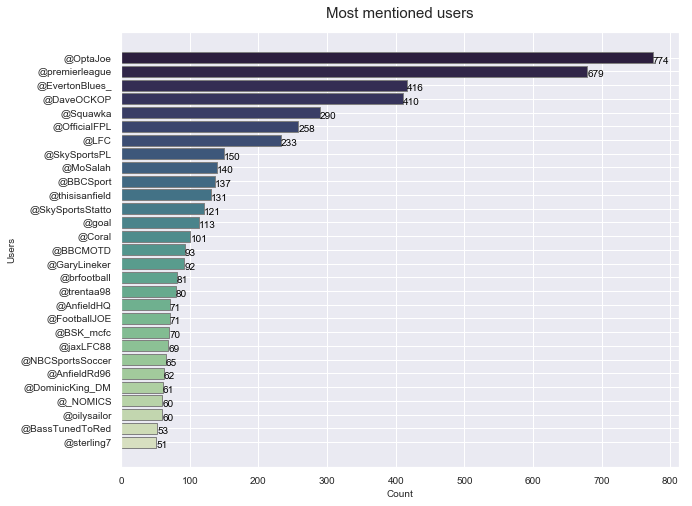

In [12]:
# same for users 
at = "@"
users = [word for word in text_clean_3 if at in word]
users = pd.Series(users).value_counts()
counter_plotter(data = users, values = 29, title = "Most mentioned users", ylab = "Users")

De la misma manera, se observan que, los usuarios más mencionados corresponden a agencias de prensa, medios de comunicación y presentadores. Es curioso como el tuitero @EvertonBlues_ se cuela en el top 3, en parte explicado por la viralización de un [tweet](https://twitter.com/EvertonBlues_/status/1121844918853537793) que, durante el partido se volvió viral.

A contiuación, se almacena la lista `text` obtenida anteriormente en un archivo txt con el objetivo de dibujar el gráfico WordCloud.

NOTA: se eliminan manualmente las comillas (') que separan los strings y las comas (,)

In [ ]:
# with open("data/textwordcloud.txt", "w", encoding="utf-8") as output:
#     output.write(str(text_clean_3))

**Word Cloud**

Se realiza un gráfico WordCloud utilizando las palabras más frecuentes hayadas en los tweets, se proporciona la imágen a mayor resolución como archivo adjunto.

In [ ]:
## Word Cloud ##
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask = np.array(Image.open(os.path.join(d, "data/logo5.png")))

text = open(os.path.join(d, 'data/textwordcloud.txt'), encoding="utf-8").read()

wc  = WordCloud(max_words=1000, mask=mask, margin=10, random_state=1).generate(text)


default_colors = wc.to_array()

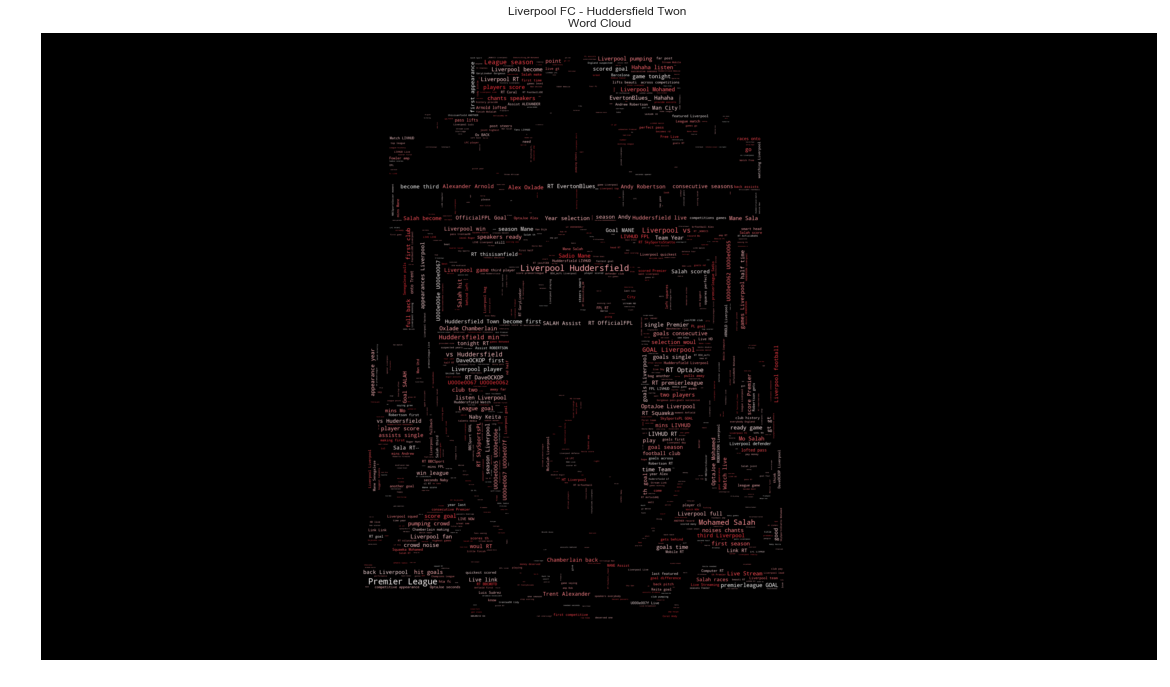

In [32]:
plt.figure(figsize=(20,15))
plt.title("Liverpool FC - Huddersfield Twon \nWord Cloud")
plt.imshow(wc.recolor(color_func=red_color_func, random_state=3), interpolation="bilinear")
plt.axis("off")
plt.show()

**Breve análisis de polaridad**

En este apartado se realizará un simple análisis de polaridad utilizando la librería vaderSentiment y su función SentimentIntensityAnalyzer(), la cual dota a un texto de 3 scores o índices: negativo, neutral, positivo y compuesto. Este último, calcula la suma normalizada de los otros tres scores, normalizada entre -1 y 1, significando que, cuanto más cerca está el score de -1, más negatividad hay en el tweet y cuanto más cerca de 1, más positividad.

In [13]:
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED)
analyser = SentimentIntensityAnalyzer()

text = raw_df[raw_df.lang == "en"].reset_index()
time_stamp = text.created_at.tolist()
text = text.text
text = text.tolist()
negative = []
neutral = []
positive = []
compound = []
for i in range(len(text)):
    aux = analyser.polarity_scores(p.clean(text[i]))
    negative.append(aux["neg"])
    neutral.append(aux["neu"])
    positive.append(aux["pos"])
    compound.append(aux["compound"])

sentiments = pd.DataFrame()
sentiments["time"] = time_stamp
sentiments["text"] = text
sentiments["negative"] = negative
sentiments["netural"] = neutral
sentiments["positive"] = positive
sentiments["Compound"] = compound
sentiments.head(10)

# let's observe sentiment behaviour through time
# it must be kept in mind that data comes time-sorted by default
# group data by time using the mean statistic
sentiments = sentiments.iloc[:,[0,2,3,4,5]]
sentiments_grouped = sentiments.groupby(["time"]).mean().reset_index()

Se observa a continuación un gráfico del índice compuesto de los tweets ordenados cronologicamente.

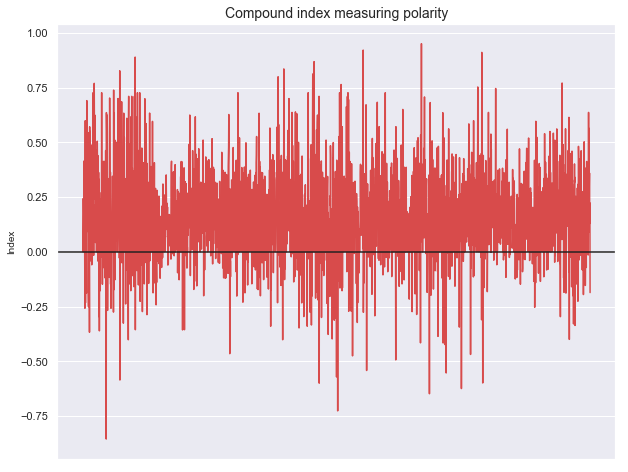

In [14]:
compound = sentiments_grouped.Compound.values
plt.figure(figsize=(10,8))
sns.set_style("darkgrid")
plt.title("Compound index measuring polarity", size = 14)
plt.plot(compound, color = "#d84b4b")
plt.xticks([])
plt.ylabel("Index", fontsize=10)
plt.axhline(y=0.0, color='#232121', linestyle='-')
plt.show()

Se determina que, aún habiendo una parte significativa de tweets con negatividad, la mayoría, según la función utilizada, muestran polaridad positiva.

Finalmente, se observa la comparación entre el índice de positividad y negatividad en un gráfico de pastel.

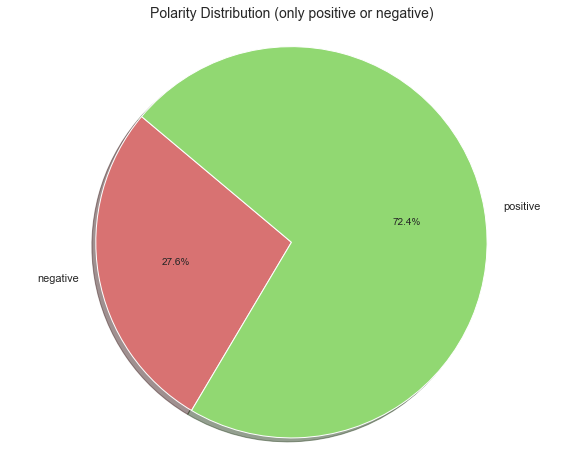

In [15]:
# cummulative sum of sentiments
cum_sum = pd.DataFrame(sentiments_grouped.iloc[:,[1,3]].sum(axis = 0)).reset_index()
cum_sum.columns = ["sentiment", "cum"]
# pie plot
labels = cum_sum.sentiment.values
sizes = cum_sum.cum.values
colors = ["#d87272", "#91d872"]

plt.figure(figsize=(10,8))
plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Polarity Distribution (only positive or negative)", fontsize=14)
plt.axis('equal')
plt.show()